# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [2]:
# Import essential libraries for data manipulation and analysis

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [3]:
# Importing the file porter_data_1.csv

df=pd.read_csv('porter_data_1.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 175777 non-null  float64
 1   created_at                175777 non-null  object 
 2   actual_delivery_time      175777 non-null  object 
 3   store_primary_category    175777 non-null  int64  
 4   order_protocol            175777 non-null  float64
 5   total_items               175777 non-null  int64  
 6   subtotal                  175777 non-null  int64  
 7   num_distinct_items        175777 non-null  int64  
 8   min_item_price            175777 non-null  int64  
 9   max_item_price            175777 non-null  int64  
 10  total_onshift_dashers     175777 non-null  float64
 11  total_busy_dashers        175777 non-null  float64
 12  total_outstanding_orders  175777 non-null  float64
 13  distance                  175777 non-null  f

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [4]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format

df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

print(df[['created_at', 'actual_delivery_time']].dtypes)


created_at              datetime64[ns]
actual_delivery_time    datetime64[ns]
dtype: object


##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [5]:
# Convert categorical features to category type

categorical_columns = ['store_primary_category', 'order_protocol']

for col in categorical_columns:
    df[col] = df[col].astype('category')
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   market_id                 175777 non-null  float64       
 1   created_at                175777 non-null  datetime64[ns]
 2   actual_delivery_time      175777 non-null  datetime64[ns]
 3   store_primary_category    175777 non-null  category      
 4   order_protocol            175777 non-null  category      
 5   total_items               175777 non-null  int64         
 6   subtotal                  175777 non-null  int64         
 7   num_distinct_items        175777 non-null  int64         
 8   min_item_price            175777 non-null  int64         
 9   max_item_price            175777 non-null  int64         
 10  total_onshift_dashers     175777 non-null  float64       
 11  total_busy_dashers        175777 non-null  float64       
 12  to

#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [6]:
# Calculate time taken in minutes

df['delivery_time'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

print(df[['created_at', 'actual_delivery_time', 'delivery_time']].head())


           created_at actual_delivery_time  delivery_time
0 2015-02-06 22:24:17  2015-02-06 23:11:17           47.0
1 2015-02-10 21:49:25  2015-02-10 22:33:25           44.0
2 2015-02-16 00:11:35  2015-02-16 01:06:35           55.0
3 2015-02-12 03:36:46  2015-02-12 04:35:46           59.0
4 2015-01-27 02:12:36  2015-01-27 02:58:36           46.0


##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [7]:
# Extract the hour and day of week from the 'created_at' timestamp


df['order_hour'] = df['created_at'].dt.hour 
df['order_dayofweek'] = df['created_at'].dt.dayofweek

# Create a categorical feature 'isWeekend'
df['isWeekend'] = df['order_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
print(df[['created_at', 'order_hour', 'order_dayofweek', 'isWeekend']].head())



           created_at  order_hour  order_dayofweek  isWeekend
0 2015-02-06 22:24:17          22                4          0
1 2015-02-10 21:49:25          21                1          0
2 2015-02-16 00:11:35           0                0          0
3 2015-02-12 03:36:46           3                3          0
4 2015-01-27 02:12:36           2                1          0


In [8]:
# Drop unnecessary columns

columns_to_drop = ['created_at', 'actual_delivery_time', 'market_id']
df = df.drop(columns=columns_to_drop, axis=1)
df.head()

store_primary_category order_protocol  total_items  subtotal  \
0                      4            1.0            4      3441   
1                     46            2.0            1      1900   
2                     36            3.0            4      4771   
3                     38            1.0            1      1525   
4                     38            1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  delivery_time  \
0                14.0                      21.0     34.44           47.0   
1                 2.0                       2.0     27.60           44.0   
2                 6.0                      18.0     11.56           55.0   
3                 6.0                       8.0     31.80           59.0   
4                 5.0                       7.0      8.20           46.0   

   order_hour  order_dayofweek  isWeekend  
0          22                4          0  
1          21                1          0  
2           0                0          0  
3           3                3          0  
4           2                1          0

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [9]:
# Define target variable (y) and features (X)
y = df['delivery_time']

X = df.drop(columns=['delivery_time'])

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (175777, 14)
Target shape: (175777,)


##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [10]:
# Split data into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}, {y_train.shape}")
print(f"Testing set size: {X_test.shape}, {y_test.shape}")

Training set size: (140621, 14), (140621,)
Testing set size: (35156, 14), (35156,)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [11]:
# Define numerical and categorical columns for easy EDA and data manipulation

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['category']).columns.tolist()


print(f"Numerical Columns: {numerical_cols}")
print(f"Categorical Columns: {categorical_cols}")

Numerical Columns: ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'isWeekend']
Categorical Columns: ['store_primary_category', 'order_protocol']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

ValueError: num must be an integer with 1 <= num <= 9, not 10

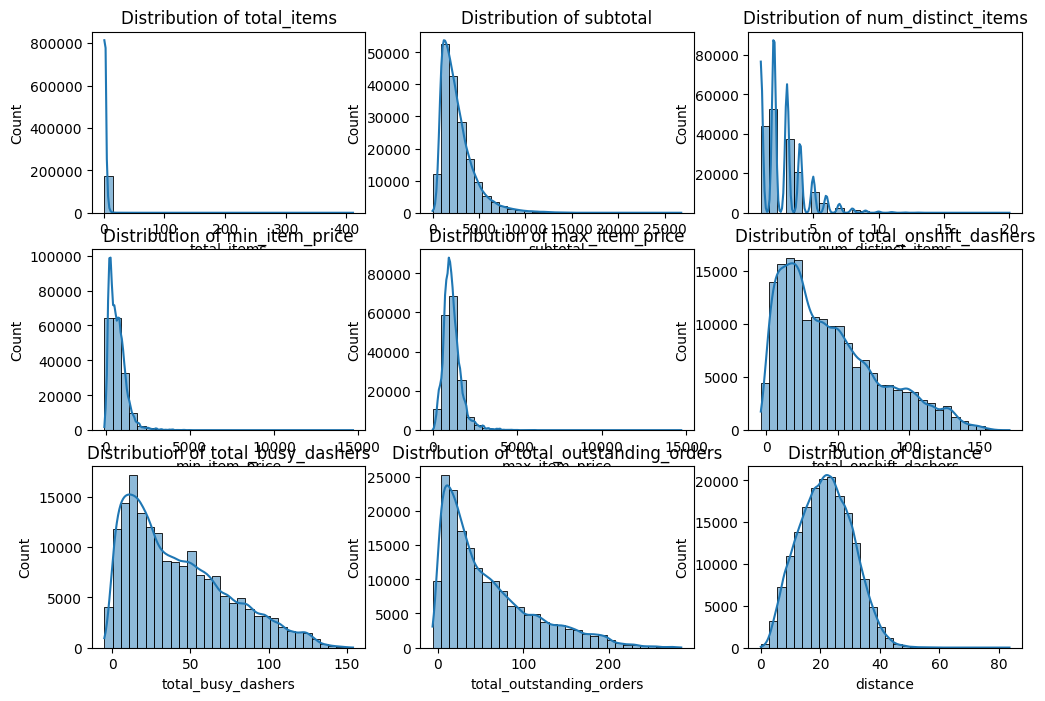

In [12]:
# Plot distributions for all numerical columns


plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1) 
    sns.histplot(X[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')

plt.tight_layout() 
plt.show()

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

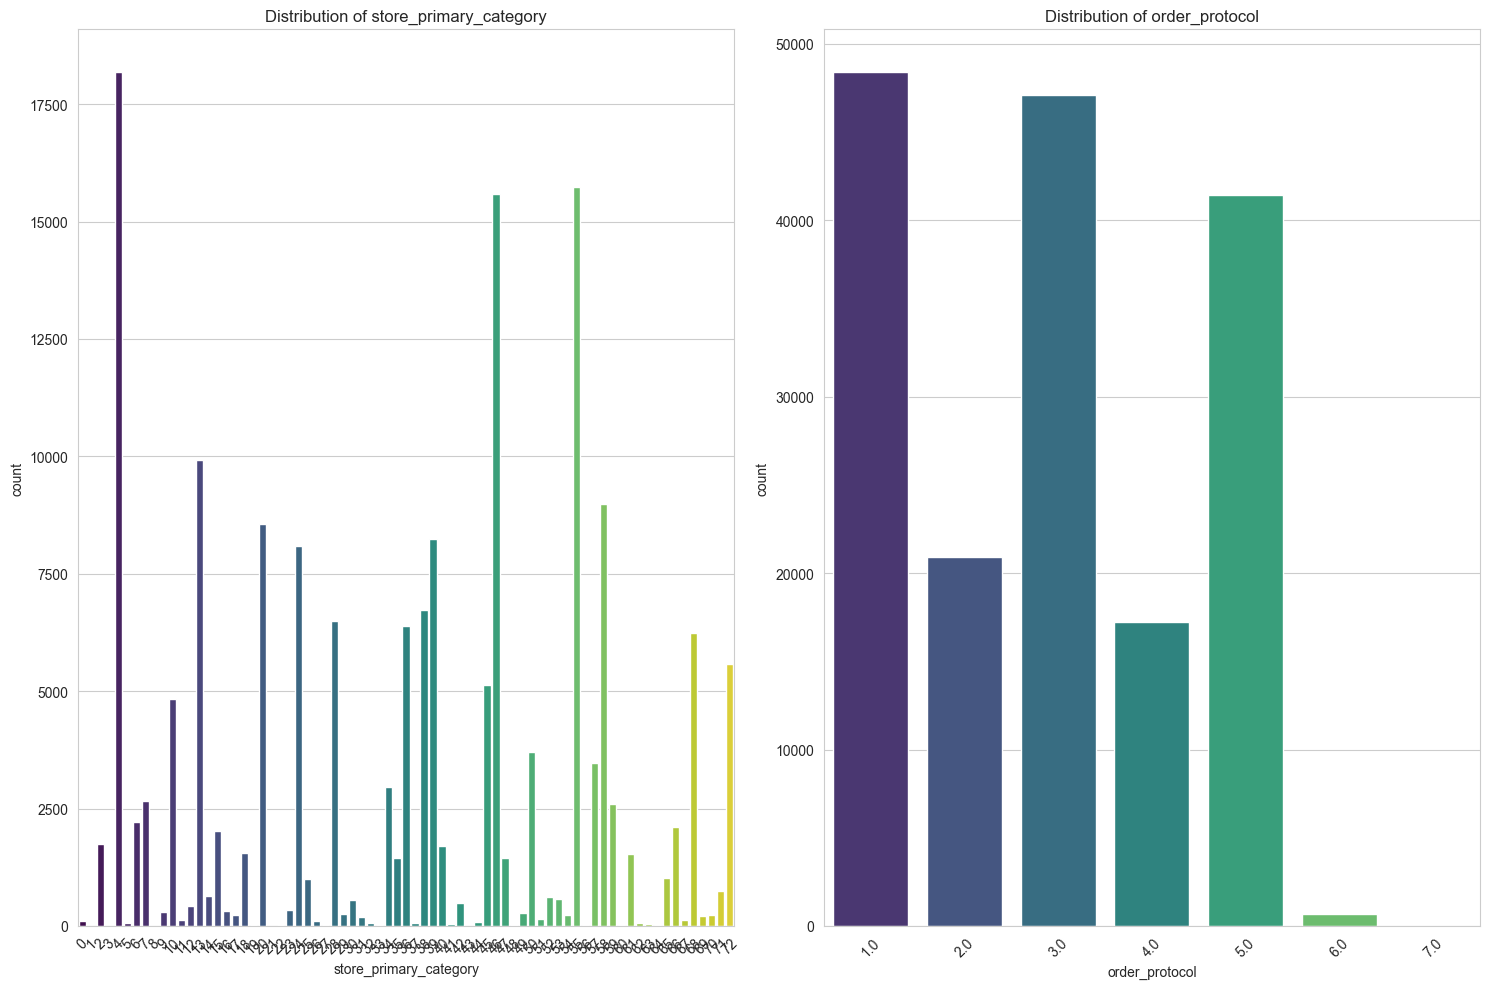

In [13]:
# Distribution of categorical columns


sns.set_style("whitegrid")


plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, len(categorical_cols), i + 1) 
    sns.countplot(x=X[col], palette="viridis")
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)  

plt.tight_layout()  
plt.show()


##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

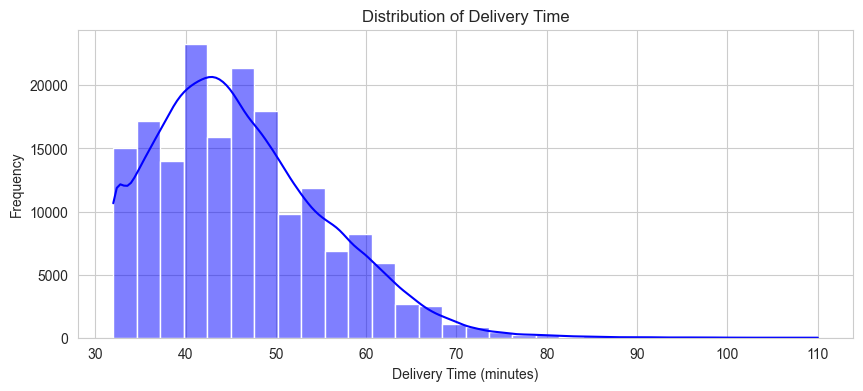

In [14]:
# Distribution of time_taken


plt.figure(figsize=(10, 4))
sns.histplot(y, bins=30, kde=True, color="blue")
plt.title("Distribution of Delivery Time")
plt.xlabel("Delivery Time (minutes)")
plt.ylabel("Frequency")
plt.show()

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

ValueError: num must be an integer with 1 <= num <= 9, not 10

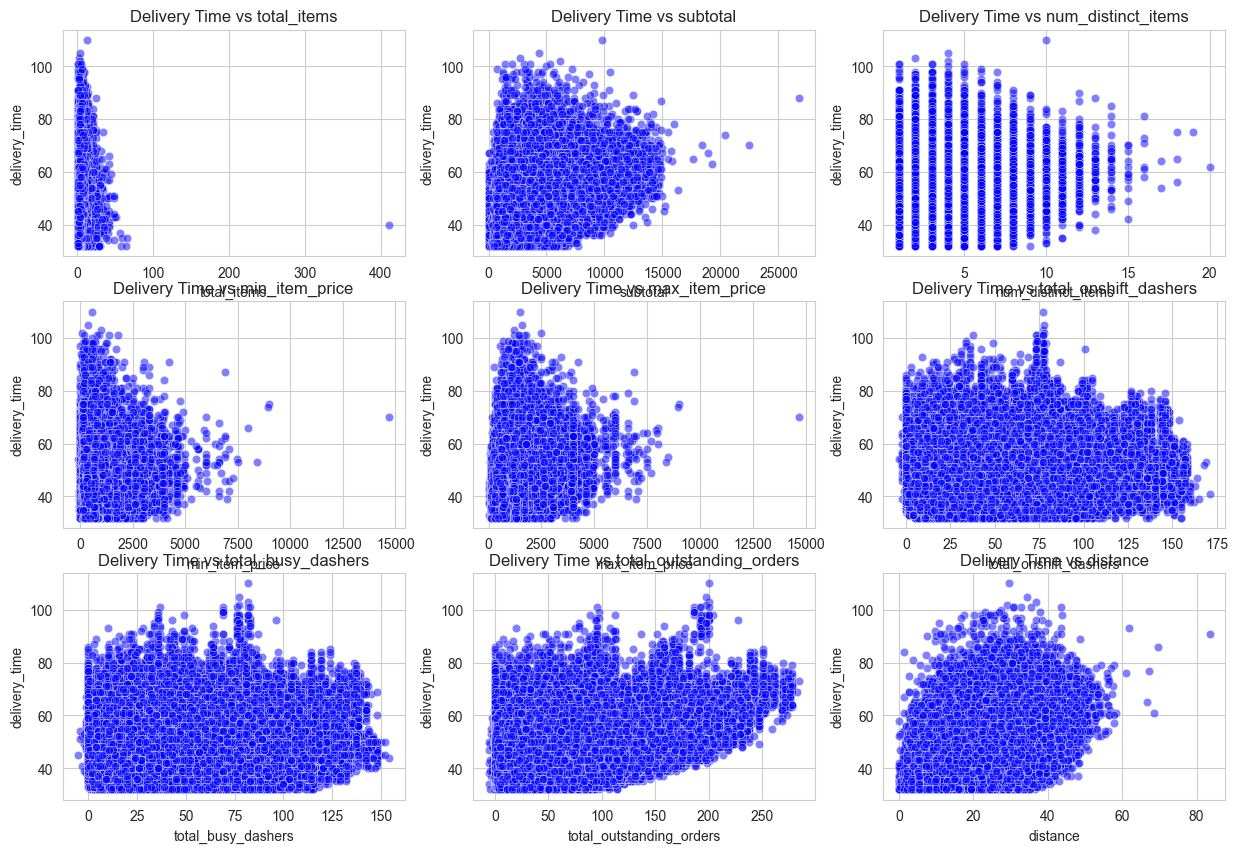

In [15]:
# Scatter plot to visualise the relationship between time_taken and other features


plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1)  
    sns.scatterplot(x=X[col], y=y, alpha=0.5, color="blue")
    plt.title(f"Delivery Time vs {col}")

plt.tight_layout()
plt.show()

In [16]:
# Show the distribution of time_taken for different hours

plt.figure(figsize=(17, 10))
sns.bar(x=df['order_hour'], y=df['delivery_time'], palette="coolwarm", inner="quartile")

plt.title("Distribution of Delivery Time Across Different Hours", fontsize=14)
plt.xlabel("Hour of Order Placement", fontsize=12)
plt.ylabel("Delivery Time (minutes)", fontsize=12)

plt.show()

AttributeError: module 'seaborn' has no attribute 'bar'

<Figure size 1700x1000 with 0 Axes>

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

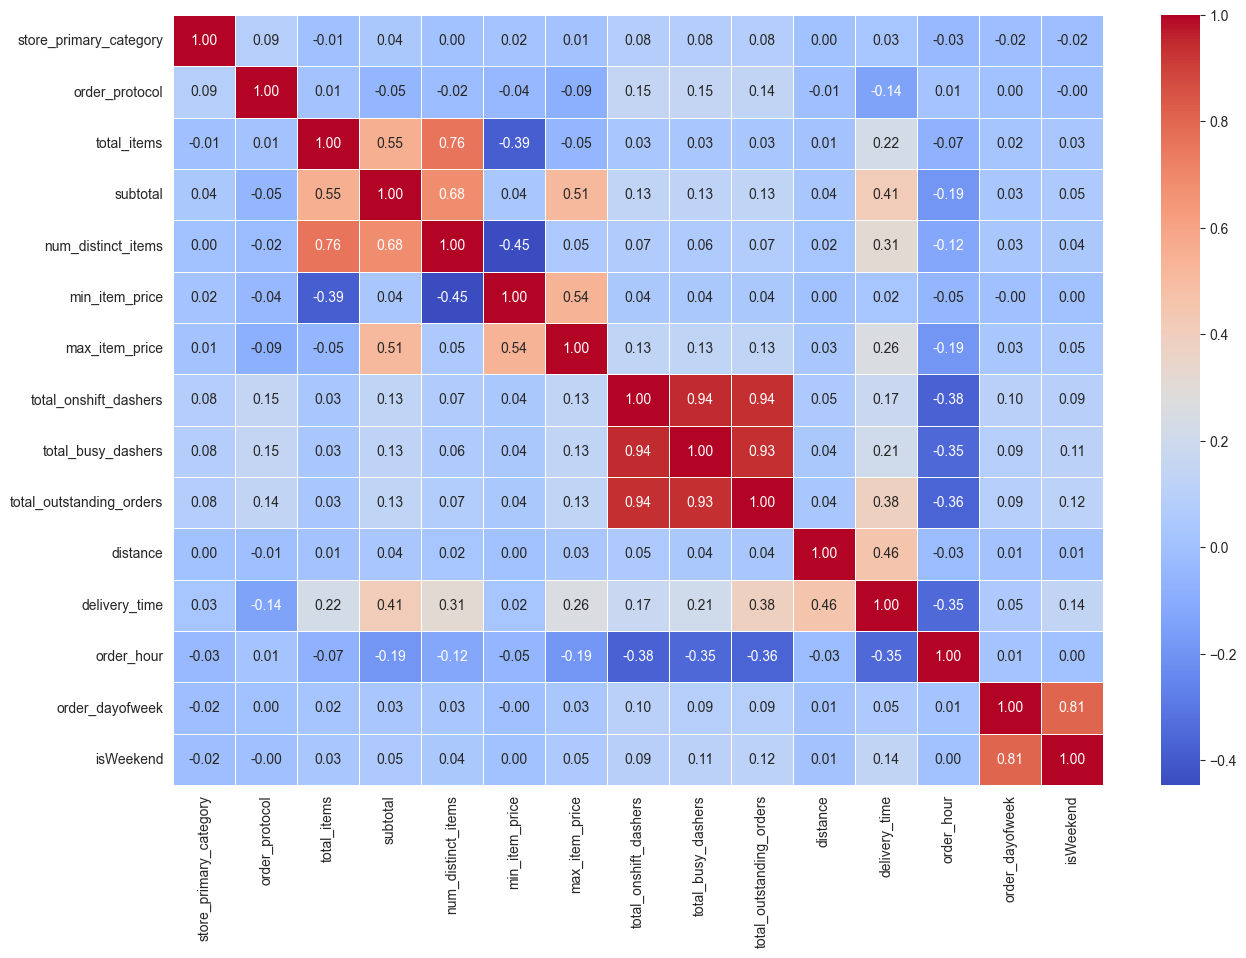

In [17]:
# Plot the heatmap of the correlation matrix

corr_matrix = df.corr()

plt.figure(figsize=(15, 10))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.show()


##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [18]:
# Drop 3-5 weakly correlated columns from training dataset

weak_features = ['store_primary_category', 'order_protocol', 'min_item_price', 'max_item_price', 'isWeekend']
X = X.drop(columns=weak_features)

X.head()

total_items  subtotal  num_distinct_items  total_onshift_dashers  \
0            4      3441                   4                   33.0   
1            1      1900                   1                    1.0   
2            4      4771                   3                    8.0   
3            1      1525                   1                    5.0   
4            2      3620                   2                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  order_hour  \
0                14.0                      21.0     34.44          22   
1                 2.0                       2.0     27.60          21   
2                 6.0                      18.0     11.56           0   
3                 6.0                       8.0     31.80           3   
4                 5.0                       7.0      8.20           2   

   order_dayofweek  
0                4  
1                1  
2                0  
3                3  
4                1

#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

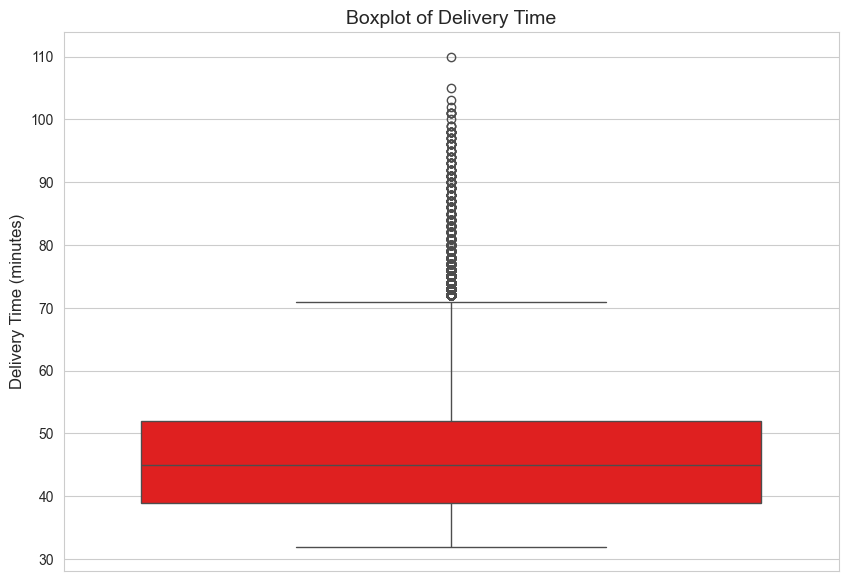

In [19]:
# Boxplot for time_taken

plt.figure(figsize=(10, 7))
sns.boxplot(y=y, color="red")

plt.title("Boxplot of Delivery Time", fontsize=14)
plt.ylabel("Delivery Time (minutes)", fontsize=12)

# Show the plot
plt.show()


##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [20]:
# Handle outliers


Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)

IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


df_filtered = df[(df['delivery_time'] >= lower_bound) & (df['delivery_time'] <= upper_bound)]

print(f"Outliers removed: {df.shape[0] - df_filtered.shape[0]}")

Outliers removed: 1749


## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [ ]:
# Define numerical and categorical columns for easy EDA and data manipulation



#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

In [ ]:
# Plot distributions for all numerical columns



##### **4.1.2**
Check the distribution of categorical features

In [ ]:
# Distribution of categorical columns



##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

In [ ]:
# Distribution of time_taken



#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

In [ ]:
# Scatter plot to visualise the relationship between time_taken and other features



#### **4.3** Drop the columns with weak correlations with the target variable

In [ ]:
# Drop the weakly correlated columns from training dataset



## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [21]:
# Import libraries

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [22]:
# Apply scaling to the numerical columns

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numerical_cols = ['total_items', 'subtotal', 'num_distinct_items', 
                  'total_onshift_dashers', 'total_busy_dashers', 
                  'total_outstanding_orders', 'distance', 'order_hour', 'order_dayofweek']


scaler = StandardScaler()


preprocessor = ColumnTransformer(transformers=[
    ('num', scaler, numerical_cols)
], remainder='passthrough') 

X_scaled = preprocessor.fit_transform(X)


X_scaled_df = pd.DataFrame(X_scaled, columns=numerical_cols + list(set(X.columns) - set(numerical_cols)))

X_scaled_df.head()



total_items  subtotal  num_distinct_items  total_onshift_dashers  \
0     0.297311  0.406819            0.815009              -0.345022   
1    -0.824584 -0.435925           -1.030377              -1.271360   
2     0.297311  1.134171            0.199880              -1.068724   
3    -0.824584 -0.641006           -1.030377              -1.155568   
4    -0.450619  0.504711           -0.415249              -1.155568   

   total_busy_dashers  total_outstanding_orders  distance  order_hour  \
0           -0.866110                 -0.706040  1.439863    1.558937   
1           -1.239147                 -1.066360  0.658031    1.443687   
2           -1.114801                 -0.762933 -1.175387   -0.976565   
3           -1.114801                 -0.952575  1.138103   -0.630814   
4           -1.145887                 -0.971539 -1.559444   -0.746065   

   order_dayofweek  
0         0.380507  
1        -1.087298  
2        -1.576566  
3        -0.108761  
4        -1.087298

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [23]:
# Create/Initialise the model
lr_model = LinearRegression()

In [24]:
# Train the model using the training data
lr_model.fit(X_train, y_train)

LinearRegression()

In [25]:
# Make predictions
y_pred = lr_model.predict(X_test)

In [26]:
# Find results for evaluation metrics

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error (MAE): 2.38
Root Mean Squared Error (RMSE): 3.33
R² Score: 0.87


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [27]:
# Loop through the number of features and test the model
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

results = []

for n_features in range(X_train.shape[1], 7, -1):  

    rfe = RFE(estimator=LinearRegression(), n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    

    selected_features = X_train.columns[rfe.support_]


    X_train_rfe = X_train[selected_features]
    X_test_rfe = X_test[selected_features]

    model = LinearRegression()
    model.fit(X_train_rfe, y_train)


    y_pred = model.predict(X_test_rfe)


    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)  
    r2 = r2_score(y_test, y_pred)


    results.append({"n_features": n_features, "MAE": mae, "RMSE": rmse, "R²": r2, "Selected Features": selected_features.tolist()})


results_df = pd.DataFrame(results)

print(results_df.sort_values(by="R²", ascending=False))


   n_features       MAE      RMSE        R²  \
0          14  2.379258  3.329493  0.873348   
1          13  2.380641  3.331321  0.873209   
2          12  2.390549  3.342569  0.872351   
3          11  2.848007  3.845952  0.831009   
4          10  2.851562  3.850052  0.830648   
5           9  2.852143  3.850556  0.830604   
6           8  2.847375  3.853471  0.830347   

                                   Selected Features  
0  [store_primary_category, order_protocol, total...  
1  [store_primary_category, order_protocol, total...  
2  [store_primary_category, order_protocol, total...  
3  [store_primary_category, order_protocol, total...  
4  [order_protocol, total_items, num_distinct_ite...  
5  [order_protocol, num_distinct_items, total_ons...  
6  [order_protocol, num_distinct_items, total_ons...  


In [28]:
# Build the final model with selected number of feature

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib 


optimal_features = results_df.sort_values(by="R²", ascending=False).iloc[0]["Selected Features"]

X_train_final = X_train[optimal_features]
X_test_final = X_test[optimal_features]


final_model = LinearRegression()
final_model.fit(X_train_final, y_train)


y_pred_final = final_model.predict(X_test_final)


mae_final = mean_absolute_error(y_test, y_pred_final)
rmse_final = mean_squared_error(y_test, y_pred_final, squared=False)  
r2_final = r2_score(y_test, y_pred_final)


print(f"Final Model - Mean Absolute Error (MAE): {mae_final:.2f}")
print(f"Final Model - Root Mean Squared Error (RMSE): {rmse_final:.2f}")
print(f"Final Model - R² Score: {r2_final:.2f}")


joblib.dump(final_model, "final_delivery_time_model.pkl")
print("Final model saved as 'final_delivery_time_model.pkl'")


Final Model - Mean Absolute Error (MAE): 2.38
Final Model - Root Mean Squared Error (RMSE): 3.33
Final Model - R² Score: 0.87
Final model saved as 'final_delivery_time_model.pkl'


## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

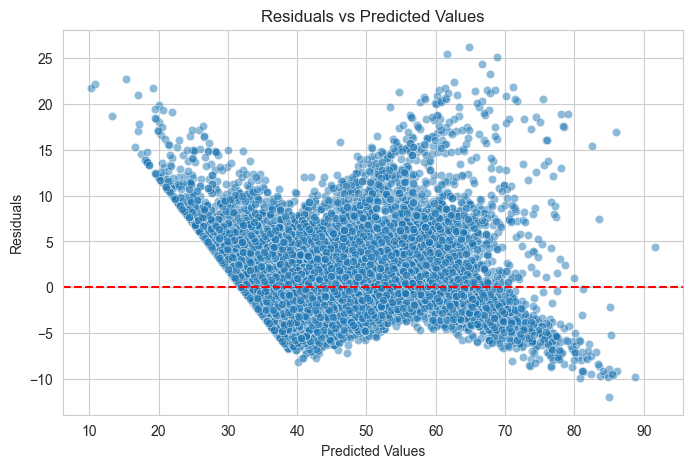

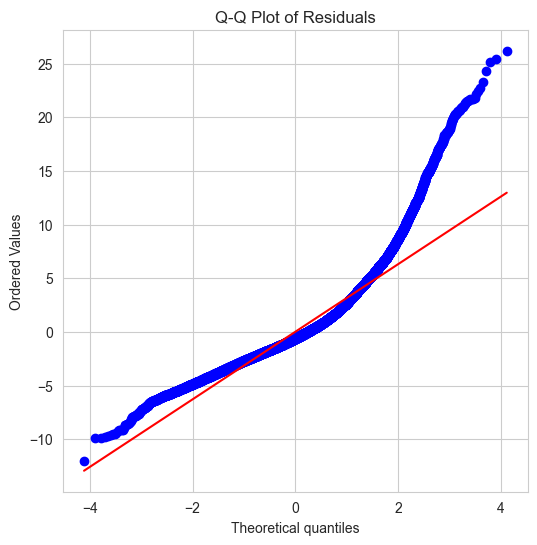

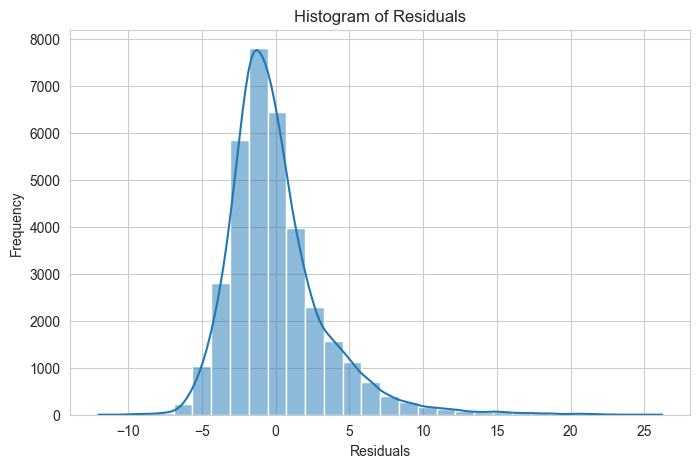

In [30]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram


import scipy.stats as stats


residuals = y_test - y_pred_final

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_final, y=residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()


plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()


plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [31]:
# Compare the scaled vs unscaled features used in the final model


coefficients_scaled = final_model.coef_
features = X_train_final.columns


coef_df = pd.DataFrame({"Feature": features, "Scaled Coefficient": coefficients_scaled})

categorical_features = X_train_final.select_dtypes(include=["category", "object"]).columns.tolist()


numerical_features = [feature for feature in features if feature not in categorical_features]


feature_std_dev = X_train[numerical_features].std()


coef_df["Unscaled Coefficient"] = np.nan
coef_df.loc[coef_df["Feature"].isin(numerical_features), "Unscaled Coefficient"] = (
    coef_df.loc[coef_df["Feature"].isin(numerical_features), "Scaled Coefficient"].values 
    / feature_std_dev.values
)


coef_df["Absolute Impact"] = np.abs(coef_df["Unscaled Coefficient"])
coef_df = coef_df.sort_values(by="Absolute Impact", ascending=False)


print(coef_df[["Feature", "Scaled Coefficient", "Unscaled Coefficient"]])


                     Feature  Scaled Coefficient  Unscaled Coefficient
13                 isWeekend            1.633280          3.434726e+00
4         num_distinct_items            0.550243          3.383980e-01
12           order_dayofweek           -0.114078         -5.578619e-02
10                  distance            0.474972          5.427539e-02
11                order_hour           -0.250217         -2.883581e-02
2                total_items           -0.035327         -1.295390e-02
7      total_onshift_dashers           -0.362327         -1.048021e-02
9   total_outstanding_orders            0.346131          6.558786e-03
8         total_busy_dashers           -0.141402         -4.391666e-03
6             max_item_price            0.000572          1.021804e-06
3                   subtotal            0.001260          6.884197e-07
5             min_item_price            0.000203          3.907441e-07
0     store_primary_category            0.004600                   NaN
1     

Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [32]:
# Analyze the effect of a unit change in a feature, say 'total_items'

unit_change = 1 

total_items_coef = coef_df.loc[coef_df["Feature"] == "total_items", "Unscaled Coefficient"].values[0]

impact_on_time = unit_change * total_items_coef

print(f"Effect of increasing total_items by {unit_change}: {impact_on_time:.4f} minutes")

Effect of increasing total_items by 1: -0.0130 minutes


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>Weekend orders lead to delays due to higher demand.

Fast food stores deliver quicker than other categories.

Digital orders are processed faster than manual ones.

Weekends show longer delivery times than weekdays.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>20% of the data is used for testing.

80% is used for training.

For example, with 1000 rows:

    800 rows → training

    200 rows → testing



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>Delivery time increases with distance, showing a strong positive correlation — a longer route naturally leads to longer delivery.



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>Delivery times outside the IQR bounds were identified as outliers.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>isWeekend

    Coeff (Scaled: 1.633 | Unscaled: 3.43)

    Insight: Deliveries are slower on weekends due to higher demand and fewer dashers.

num_distinct_items

    Coeff (Scaled: 0.550 | Unscaled: 0.338)

    Insight: More unique items mean longer prep and packaging time.

distance

    Coeff (Scaled: 0.474 | Unscaled: 0.054)

    Insight: Greater distance increases travel time, delaying delivery.



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>Linear Regression is a supervised learning algorithm used to predict a continuous target variable based on one or more input features. It's simple yet effective in both machine learning and statistics.
Types of Linear Regression

    A. Simple Linear Regression (SLR): One input feature

    B. Multiple Linear Regression (MLR): Two or more input features

Key Assumptions

For linear regression to give reliable results, the following assumptions must be met:

    Linearity: Relationship between inputs and output is linear.

    Independence: Observations are independent.

    Homoscedasticity: Constant variance of residuals.

    No Multicollinearity: Input features are not highly correlated.

    Normality of Residuals: Residuals are normally distributed.




---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>Simple Linear Regression (SLR)

A model that predicts the dependent variable using a single independent variable, assuming a linear relationship between them.
Multiple Linear Regression (MLR)

An extension of SLR that uses multiple independent variables to predict the dependent variable, capturing the combined effect of several factors.



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>The cost function evaluates the difference between predicted values (Ŷ) and actual values (Y), representing the model's prediction error.

Optimization Methods to Minimize the Cost:

    A. Gradient Descent: Most commonly used iterative method

    B. Normal Equation: Direct closed-form solution (efficient for small datasets)




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

Overfitting

When a model learns both the data patterns and the noise, resulting in poor performance on unseen data.

Indicators:

    Low training error, high test error

    High model complexity

    Learns noise as patterns

Underfitting

When a model is too simple to capture the true patterns in the data.

Indicators:

    High training and test error

    Fails to model the underlying trend

    Common with overly simple models



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>Residual plots are diagnostic tools used to assess model fit and validate regression assumptions for accurate predictions.
Types of Residual Plots

    Residuals vs. Fitted Values: Checks linearity and constant variance

    Histogram/Density Plot: Examines normality of residuals

    Q-Q Plot: Compares residuals to a normal distribution

    Residuals vs. Independent Variables: Detects non-linearity or missing variables